**Temat:** Analiza sentymentu w tekstach internetowych w oparciu o sieci typu Transformer

**Wprowadzenie:** Analiza sentymentu to technika przetwarzania języka naturalnego (NLP), która identyfikuje ton emocjonalny w tekście, klasyfikując go na pozytywny, negatywny lub neutralny. Wykorzystuje się ją do badania opinii klientów, monitorowania reputacji marki czy analizy treści mediów społecznościowych.

**Cel projektu:** Celem projektu jest opracowanie i implementacja modelu analizy sentymentu, który pozwoli na klasyfikację opinii użytkowników na podstawie tekstów pochodzących z Internetu. Należy przeanalizować dane tekstowe, przygotować odpowiedni model oraz zaprezentować wyniki analizy.

### Konfiguracja środowiska 

In [10]:
!pip3 install datasets langdetect transformers accelerate 'numpy<2' torch nltk jieba matplotlib wordcloud --quiet



[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


#### Opcjonalne: przy problemach nltk z ssl (częste na macOS)

In [1]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

### Ładowanie danych

In [ ]:
from datasets import load_dataset
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

In [25]:
def is_target_language(text, target_lang):
    try:
        detected = detect(text)
        return detected == target_lang
    except LangDetectException:
        return False

def load_and_filter_dataset(languages, split, max_rows=20000, seed=42):
    train_ds = load_dataset("clapAI/MultiLingualSentiment", split=split)
    
    filtered_datasets = {}
    
    for lang in languages:
        # Filter by language
        lang_dataset = train_ds.filter(
            lambda batch: [x == lang for x in batch['language']],
            batched=True,
            num_proc=4
        )

        # Further filter by text content for English
        if lang == 'en':
            lang_dataset = lang_dataset.select(range(max_rows * 2))
            lang_dataset = lang_dataset.filter(
                lambda x: is_target_language(x['text'], 'en'),
                num_proc=4
            )

        
        # Select randomly max_rows examples
        if lang_dataset.num_rows > max_rows:
            # Shuffle the dataset with a fixed seed for reproducibility
            lang_dataset = lang_dataset.shuffle(seed=seed)
            # Select the first max_rows after shuffling
            lang_dataset = lang_dataset.select(range(max_rows))
            
        filtered_datasets[lang] = lang_dataset
        print(f"Loaded {lang_dataset.num_rows} rows for {lang}")
    
    return filtered_datasets

# Use the function with selected languages
test_languages = ['en', 'es', 'zh']
train_dataset = load_and_filter_dataset(test_languages, 'train')



Filter (num_proc=4): 100%|██████████| 40000/40000 [00:36<00:00, 1104.00 examples/s]


Loaded 20000 rows for en
Loaded 20000 rows for es
Loaded 20000 rows for zh


In [26]:
import pandas as pd
# Convert the datasets to pandas DataFrames for easier manipulation

print(pd.DataFrame(train_dataset['en'][:10])[['text', 'label']])

                                                text     label
0  i feel like im slaughtering the tender feeling...  positive
1  Excellent value for money. This is the best mi...  positive
2  This movie has its ups and downs, but to me th...  positive
3                                      Is convenint.  positive
4  Easy to order and much quicker delivery than o...  positive
5  An easy, happy escape\nMakes me smile every ti...  positive
6  i suspect ill go into next years race feeling ...  positive
7  Awesome Experince!! Waiting for more feature u...  positive
8           Prompt delivery courteous delivery rider  positive
9  Beautiful Venue, Great food, Great Wine Tastin...  positive


In [27]:
from datasets import concatenate_datasets

test_ds_list = [train_dataset[lang] for lang in test_languages]
concatenated_dataset = concatenate_datasets(test_ds_list)

## Zero-shot Prompting

In [26]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch


model_name = 'Qwen/Qwen3-0.6B'
tokenizer = AutoTokenizer.from_pretrained(model_name)
# For MacBooks with CPU Intel you have to set device_map as cpu and torch_dtype as torch.float32 
# otherwise it doesn't compile
zero_shot_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float32,
    device_map={"": "cpu"})
zero_shot_model.eval()

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 1024)
    (layers): ModuleList(
      (0-27): 28 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
        (post_attention_layernorm): Qwe

In [27]:
# Prompt template
def build_prompt(text):
    return f"Just define in one word the sentiment of this text as positive, negative or neutral:\n\"{text}\"\nAnswer(positive/negative/neutral):\n"

def predict_sentiment(text):
    prompt = build_prompt(text)
    zero_shot_model_inputs = tokenizer(prompt, return_tensors="pt").to(zero_shot_model.device)
    generated_ids = zero_shot_model.generate(**zero_shot_model_inputs, max_new_tokens=3)
    answer = tokenizer.batch_decode(generated_ids)[0][len(prompt):]
    return answer

In [ ]:
print(concatenated_dataset[0]['text'])
print(predict_sentiment(concatenated_dataset[0]['text']))
print(f'\nReal answer:\n{concatenated_dataset[0]['label']}')

I'm really surprised this Gamestop was not in Yelp. I stopped here for the Xbox One launch and was really impressed with this store. They were very organized and had a line with some staff out front explaining the launch. It went very smooth and I think everyone was happy with it.\n\nI came back about a month later to return a couple items that we also got as gifts for the holidays and they were very cool about it. I had my receipts so that made it simple but they were also really friendly and professional. Pretty cool and they know their gaming.
Answer:
positive

Real answer:
positive


### Test Zero-shot prompting

In [31]:

# Mapping dataset and get estimates from LLM
def process(result, row):
    text = row['text']
    answer = predict_sentiment(text)
    if row['label'] in answer:
        result[row['language']] += 1

# Calculate total and for each language accuracy
def calc_accuracy(result, ds):
    accuracy = {}
    for lang in result:
        lang_total = ds.filter(
            lambda batch: [x == lang for x in batch['language']],
            batched = True,
            num_proc = 4
        ).num_rows
        accuracy[lang] = result[lang]/lang_total
    total_accuracy = sum(result.values()) / ds.num_rows
    accuracy['total'] = total_accuracy
    return accuracy


In [33]:

zero_shot_results = {lang:0 for lang in test_languages}
train_dataset['en'].map(lambda row: process(zero_shot_results, row))
zero_shot_accuracy = calc_accuracy(zero_shot_results, train_dataset['en'])

Map:   0%|          | 23/100000 [00:21<26:32:20,  1.05 examples/s]


KeyboardInterrupt: 

Dokładność dla zero-shot prompting

In [ ]:
print(f"{'Język':<10} {'Dokładność':<10}")
print('-' * 22)
for lang, acc in zero_shot_accuracy.items():
    print(f"{lang:<10} {acc:<10.2f}")

    

### LoRA

### Wizualizacja danych

#### Preprocessing

Wymaga przełączenia kernelu na spacy-env

In [ ]:
!python3 -m pip install certifi
!export SSL_CERT_FILE=$(python3 -m certifi)

In [12]:
!pip3 install nltk spacy jieba matplotlib wordcloud spacy --quiet
!python3 -m spacy download en_core_web_sm --quiet
!python3 -m spacy download es_core_news_sm --quiet
!python3 -m spacy download zh_core_web_sm --quiet



[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 189, in _run_module_as_main
  File "<frozen runpy>", line 148, in _get_module_details
  File "<frozen runpy>", line 112, in _get_module_details
  File "/Users/michalklos/Studia_Projekty/NLP/Multilingual-sentiment-analysis/torch-env/lib/python3.11/site-packages/spacy/__init__.py", line 6, in <module>
    from .errors import setup_default_warnings
  File "/Users/michalklos/Studia_Proj

In [13]:
import re
import nltk
import spacy
import jieba
from nltk.corpus import stopwords

Opcjonalne: przy problemach nltk z SSL:

In [5]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [14]:
nltk.download('stopwords')

# Initialize spacy models
nlp_models = {
    'en': spacy.load('en_core_web_sm'),
    'es': spacy.load('es_core_news_sm'),
    'zh': spacy.load('zh_core_web_sm')
}

# Get stopwords
stop_words = {
    'en': set(stopwords.words('english')),
    'es': set(stopwords.words('spanish')),
    'zh': set()  # Chinese doesn't use stopwords
}

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michalklos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
def remove_special_and_digits(txt, lang):
  txt = re.sub(r'[^a-zA-Z\u4e00-\u9fff\s]', '', txt)

  if lang == 'zh':
    txt = " ".join(jieba.cut(txt))

  if lang != 'zh':
    txt = txt.lower()
  
  document = nlp_models[lang](txt)

  tokens = []
  if lang == 'zh':
    # For Chinese, we don't use lemmatization
    tokens = [token.text for token in document if 
              (not token.is_stop and not token.is_space and
              len(token.text.strip()) > 0)]

  for token in document:
    if (token.text not in stop_words.get(lang, set()) and not token.is_space and 
      len(token.text.strip()) > 0):
      tokens.append(token.lemma_)
  
  return ' '.join(tokens)

def preprocess_dataset(example):
    example['preprocessed_text'] = remove_special_and_digits(
        example['text'], 
        example['language']
    )

    return example


In [28]:
print(concatenated_dataset)

preprocessed_dataset = concatenated_dataset.map(
    preprocess_dataset,
    num_proc=4, 
    batch_size=100
)

print("Original text:", preprocessed_dataset[0]['text'])
print("Preprocessed text:", preprocessed_dataset[0]['preprocessed_text'])

Dataset({
    features: ['text', 'label', 'source', 'domain', 'language'],
    num_rows: 60000
})


Map (num_proc=4):   0%|          | 19/60000 [00:01<1:01:20, 16.30 examples/s]Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/2f/ljz1r9416b1fr4bg0p4bd8p00000gn/T/jieba.cache
Map (num_proc=4):   0%|          | 199/60000 [00:02<05:55, 168.25 examples/s]Loading model cost 0.783 seconds.
Prefix dict has been built successfully.
Map (num_proc=4):  49%|████▊     | 29126/60000 [01:32<01:18, 392.90 examples/s]Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/2f/ljz1r9416b1fr4bg0p4bd8p00000gn/T/jieba.cache
Map (num_proc=4):  49%|████▉     | 29376/60000 [01:33<01:56, 263.07 examples/s]Loading model cost 0.931 seconds.
Prefix dict has been built successfully.
Map (num_proc=4): 100%|██████████| 60000/60000 [04:03<00:00, 246.63 examples/s]


Original text: i feel like im slaughtering the tender feelings that my heart felt by trying to tie them down to words but i want to remember this so here goes
Preprocessed text: feel like slaughter tender feeling heart feel try tie word want remember go


Filter: 100%|██████████| 60000/60000 [00:00<00:00, 86861.19 examples/s] 


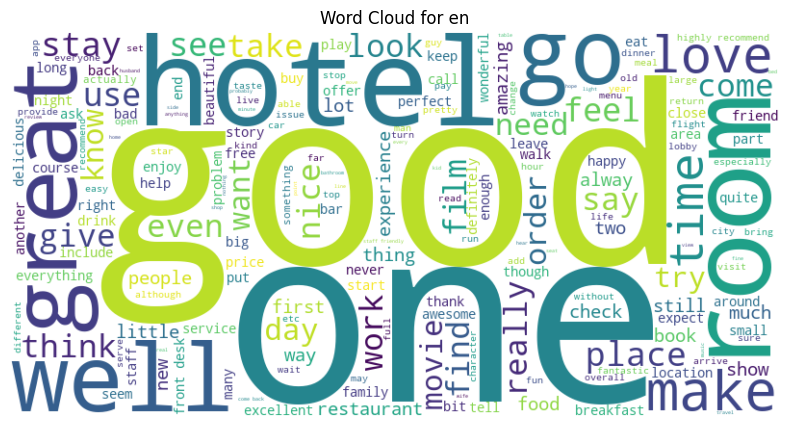

Filter: 100%|██████████| 60000/60000 [00:00<00:00, 116927.33 examples/s]


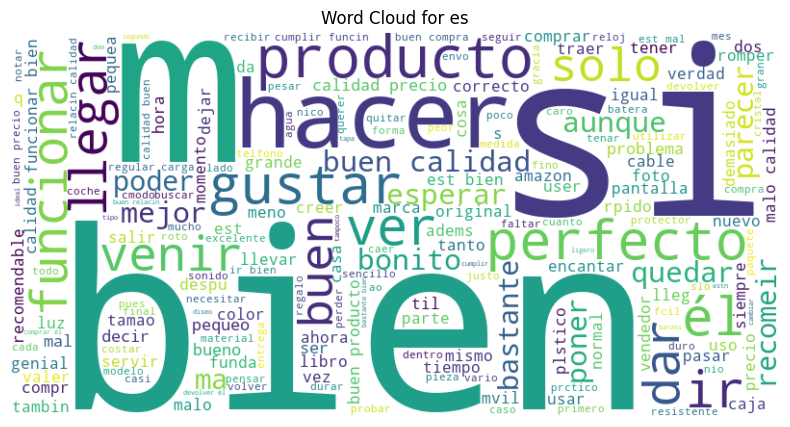

Filter: 100%|██████████| 60000/60000 [00:00<00:00, 118205.57 examples/s]


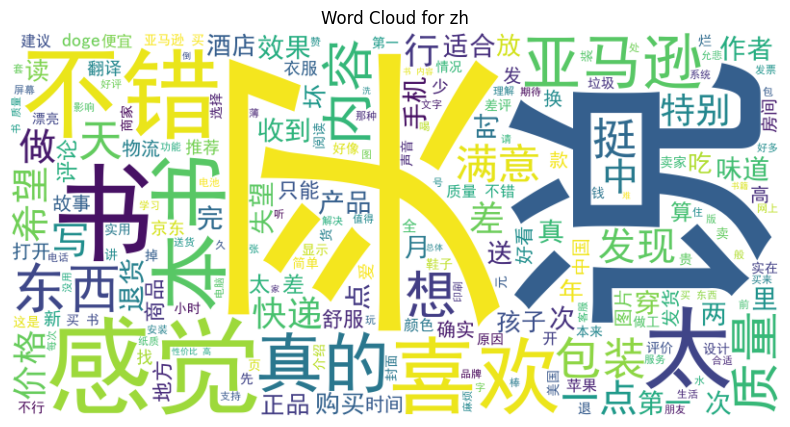

In [29]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

font_path = './resources/simhei.ttf'  # Path to a Chinese font file for word cloud

# Create word cloud for each language
for lang in test_languages:
    # Filter dataset by language
    lang_texts = ' '.join(preprocessed_dataset.filter(
        lambda x: x['language'] == lang
    )['preprocessed_text'])
    
    # Create and display word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        font_path=font_path if lang == 'zh' else None,  # Use Chinese font for Chinese text
    ).generate(lang_texts)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {lang}')
    plt.show()

    wordcloud.to_file(f'./wordclouds/wordcloud_{lang}.png')  # Save word cloud to file